In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

# Dataset
Przedstawienie przykładowych obrazów z datasetu. Wszystkie obrazy są w rozdzielczości 256 x 256. 
Dla każdej technologii fotografii satelitarnej jest po 16 000 zdjęć w 4 kategoriach: lasy, pola, góry i miasta. Są one posegregowane w folderach. Posegregowałem je w taki sposób, że porporcja zbiorów train:test:validation jest równa 7:1:2.

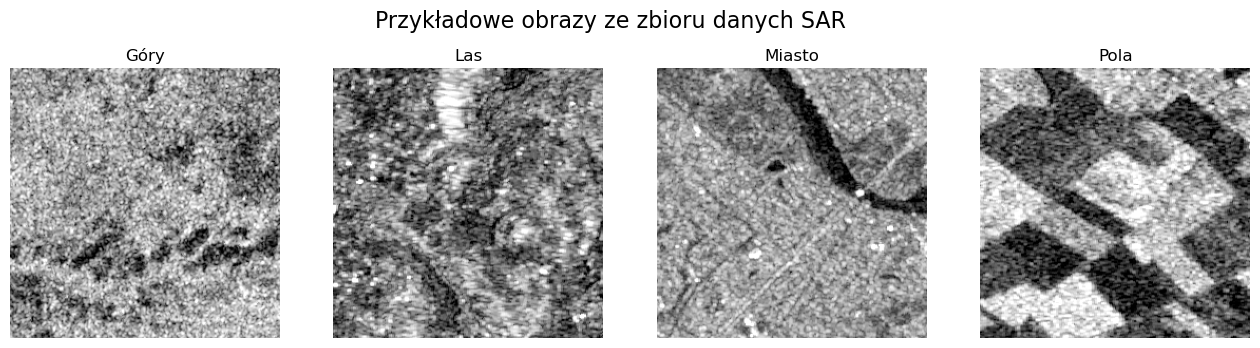

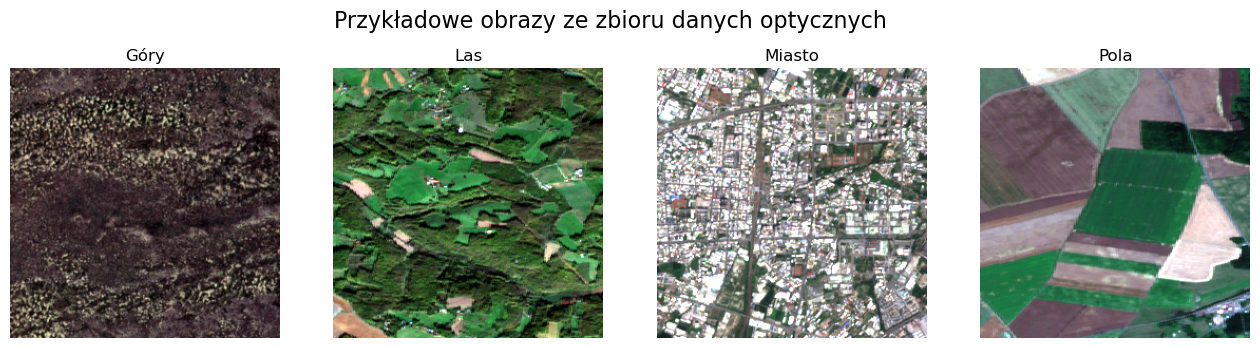

In [3]:
SAR_gora = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\SAR\train\gory\ROIs1970_fall_s1_2_p7.png"
SAR_las = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\SAR\train\lasy\ROIs1970_fall_s1_11_p98.png"
SAR_miasto =r"C:\Users\piotr\Desktop\projekt_WUM_SAR\SAR\train\miasto\ROIs1970_fall_s1_8_p196.png"
SAR_pola = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\SAR\train\pola\ROIs1868_summer_s1_59_p25.png"

OPT_gora = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\OPTICAL\train\gory\ROIs1970_fall_s2_2_p242.png"
OPT_las = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\OPTICAL\train\lasy\ROIs1970_fall_s2_11_p18.png"
OPT_miasto = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\OPTICAL\train\miasto\ROIs1970_fall_s2_13_p530.png"
OPT_pola = r"C:\Users\piotr\Desktop\projekt_WUM_SAR\OPTICAL\train\pola\ROIs1868_summer_s2_59_p120.png"
SAR_images = [SAR_gora, SAR_las, SAR_miasto, SAR_pola]
OPT_images = [OPT_gora, OPT_las, OPT_miasto, OPT_pola]
labels = ["Góry", "Las", "Miasto", "Pola"]

def display_images(images, labels, title, is_rgb=True):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)
    
    for i, (img_path, label) in enumerate(zip(images, labels)):
        img = Image.open(img_path)
        
        if not is_rgb:
            img = img.convert("L")  
        
        axes[i].imshow(img)
        if not is_rgb:
            axes[i].imshow(img, cmap='gray') 
        axes[i].set_title(label)
        axes[i].axis("off") 
    plt.show()

display_images(SAR_images, labels, "Przykładowe obrazy ze zbioru danych SAR", is_rgb=False)
display_images(OPT_images, labels, "Przykładowe obrazy ze zbioru danych optycznych", is_rgb=True)

# Model dla zdjęć optycznych 

## Wczytanie danych optycznych z folderów

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizacja wartości pikseli
    validation_split=0.2  # 20% danych na walidację
)

base_dir_optical = r'C:\Users\piotr\Desktop\projekt_WUM_SAR\OPTICAL'

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

print("Dla zbioru treningowego:")
train_generator_optical = datagen_train.flow_from_directory(
    os.path.join(base_dir_optical, 'train'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

print("Dla zbioru walidacyjnego")
validation_generator_optical = datagen_val.flow_from_directory(
    os.path.join(base_dir_optical, 'val'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

print("Dla zbioru testowego")
test_generator_optical = datagen_test.flow_from_directory(
    os.path.join(base_dir_optical, 'test'),
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Dla zbioru treningowego:
Found 11200 images belonging to 4 classes.
Dla zbioru walidacyjnego
Found 3200 images belonging to 4 classes.
Dla zbioru testowego
Found 1600 images belonging to 4 classes.


## Model referencyjny dla zdjęć optycznych

In [7]:
simple_model = Sequential([
    Input(shape=(256, 256, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_simple = simple_model.fit(train_generator_optical, validation_data=validation_generator_optical, epochs=10,
                                  callbacks=[early_stopping])

c:\Users\piotr\Python_nowy\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 128s 363ms/step - accuracy: 0.3968 - loss: 20.9614 - val_accuracy: 0.4953 - val_loss: 5.4306
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 99s 282ms/step - accuracy: 0.5291 - loss: 3.6272 - val_accuracy: 0.5572 - val_loss: 2.7563
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.5612 - loss: 2.8520 - val_accuracy: 0.5797 - val_loss: 1.6906
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.6084 - loss: 1.6205 - val_accuracy: 0.5766 - val_loss: 1.7681
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 92s 264ms/step - accuracy: 0.6024 - loss: 1.6742 - val_accuracy: 0.5622 - val_loss: 1.3288
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 266ms/step - accuracy: 0.6578 - loss: 1.1187 - val_accuracy: 0.4688 - val_loss: 2.3494
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.6387 - loss: 1.3115 - val_accuracy: 0.5678 - val_loss: 1.1790
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 95s 271ms/step - accuracy: 0.6892 - loss:

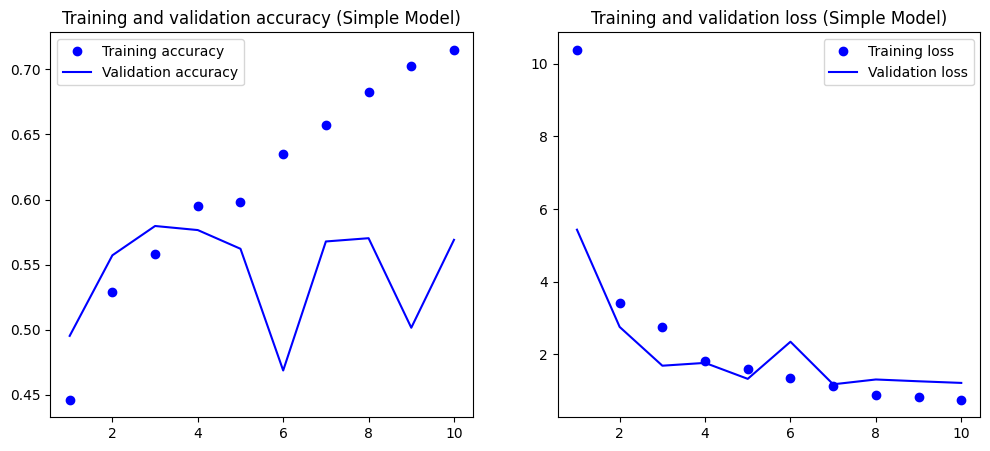

In [8]:
accuracy = history_simple.history['accuracy']
val_accuracy = history_simple.history['val_accuracy']
loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Simple Model)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Simple Model)')
plt.legend()

plt.show()

## Model docelowy dla zdjęć optycznych

In [3]:
model_optical = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l1(0.01)),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l1(0.01)),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

model_optical.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history_optical = model_optical.fit(train_generator_optical, validation_data=validation_generator_optical, epochs=10,
                                    callbacks=[early_stopping])

c:\Users\piotr\Python_nowy\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.5706 - loss: 9.5928 - val_accuracy: 0.7931 - val_loss: 2.2630
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8399 - loss: 1.7587 - val_accuracy: 0.8244 - val_loss: 1.0864
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.8480 - loss: 0.9531 - val_accuracy: 0.8406 - val_loss: 0.7998
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8733 - loss: 0.7357 - val_accuracy: 0.8662 - val_loss: 0.6671
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.8813 - loss: 0.6236 - val_accuracy: 0.8425 - val_loss: 0.6515
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9098 - loss: 0.5163 - val_accuracy: 0.8566 - val_loss: 0.6168
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9168 - loss: 0.4608 - val_accuracy: 0.8978 - val_loss: 0.4840
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9349 - loss: 0.4019 - val_accu

In [4]:
test_loss, test_accuracy = model_optical.evaluate(test_generator_optical)

print(f"Wynik na danych testowych:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.9483 - loss: 0.4058
Wynik na danych testowych:
Test Loss: 0.4973948001861572
Test Accuracy: 0.8931249976158142


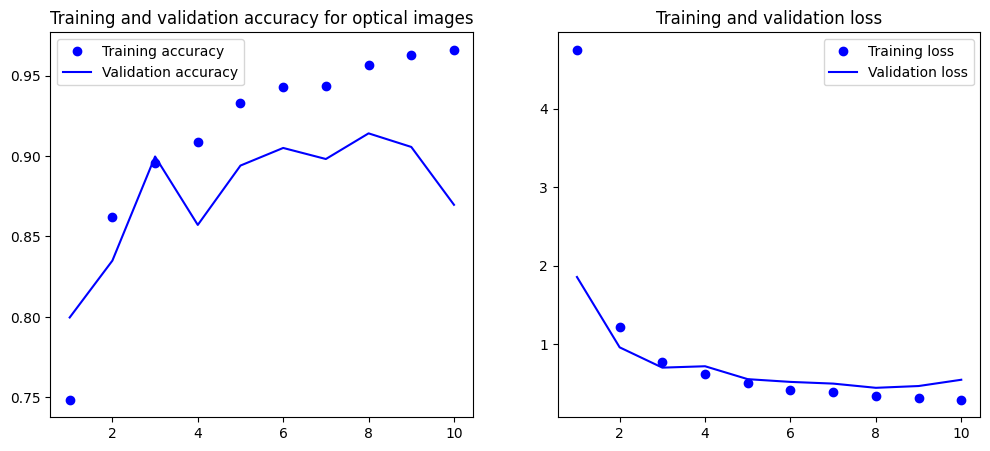

In [10]:
accuracy = history_optical.history["accuracy"]
val_accuracy = history_optical.history["val_accuracy"]
loss = history_optical.history["loss"]
val_loss = history_optical.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy for optical images')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model dla zdjęć SAR

## Stworzenie generatorów danych dla modeli SAR

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.2)
base_dir_sar = r'C:\Users\piotr\Desktop\projekt_WUM_SAR\SAR'

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val= ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

print("Dla zbioru treningowego:")
train_generator_sar = datagen_train.flow_from_directory(os.path.join(base_dir_sar,'train'),
                                                       target_size=(256,256),
                                                       batch_size=32,
                                                       class_mode = 'categorical',
                                                       color_mode= 'grayscale')
print("Dla zbioru walidacyjnego:")
validation_generator_sar = datagen_train.flow_from_directory(os.path.join(base_dir_sar,'val'),
                                                       target_size=(256,256),
                                                       batch_size=32,
                                                       class_mode = 'categorical',
                                                       color_mode= 'grayscale')
print("Dla zbioru testowego:")
test_generator_sar = datagen_train.flow_from_directory(os.path.join(base_dir_sar,'test'),
                                                       target_size=(256,256),
                                                       batch_size=32,
                                                       class_mode = 'categorical',
                                                       color_mode= 'grayscale',
                                                       shuffle=False)

Dla zbioru treningowego:
Found 11200 images belonging to 4 classes.
Dla zbioru walidacyjnego:
Found 3200 images belonging to 4 classes.
Dla zbioru testowego:
Found 1600 images belonging to 4 classes.


## Model referencyjny dla zdjęć SAR

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

simple_sar_model = Sequential([
    Input(shape=(256, 256, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

simple_sar_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_simple_sar = simple_sar_model.fit(train_generator_sar, validation_data=validation_generator_sar,
                           epochs=10, callbacks=[early_stopping])

Epoch 1/10


c:\Users\piotr\anaconda_inz\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.2442 - loss: 16.3102 - val_accuracy: 0.2594 - val_loss: 5.8540
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.2553 - loss: 5.5244 - val_accuracy: 0.2534 - val_loss: 2.1852
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.3021 - loss: 2.0182 - val_accuracy: 0.2506 - val_loss: 2.7680
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.3026 - loss: 1.9553 - val_accuracy: 0.2741 - val_loss: 1.7776
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.3298 - loss: 1.4814 - val_accuracy: 0.2556 - val_loss: 1.4213
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.3463 - loss: 1.4706 - val_accuracy: 0.2475 - val_loss: 1.4341
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.3586 - loss: 1.3637 - val_accuracy: 0.2741 - val_loss: 1.4227
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.3861 - loss: 1.3091 - val_accur

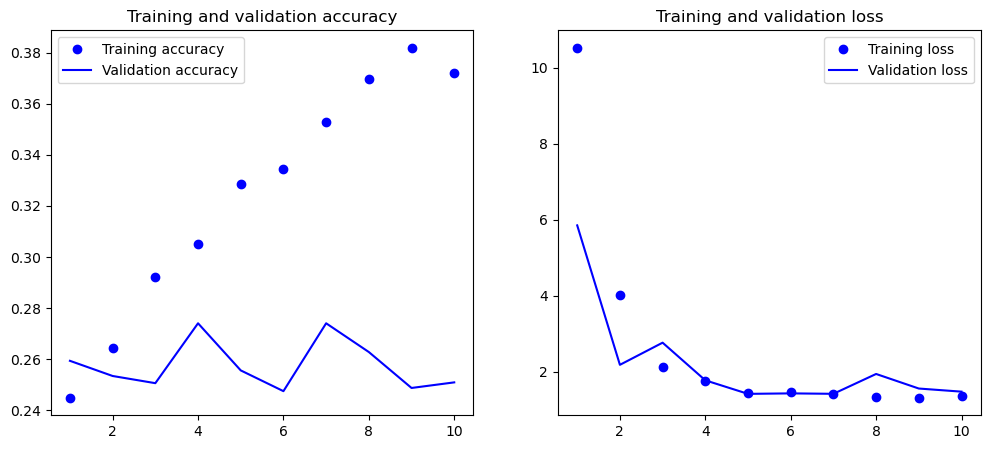

In [4]:
import matplotlib.pyplot as plt

accuracy = history_simple_sar.history['accuracy']
val_accuracy = history_simple_sar.history['val_accuracy']
loss = history_simple_sar.history['loss']
val_loss = history_simple_sar.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 1 dla zdjęć SAR

In [5]:
model_sar = Sequential([
    Input(shape=(256,256,1)),
    Conv2D(filters=64, kernel_size=3,activation='relu',kernel_regularizer=l1(0.01)),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=3, activation='relu',kernel_regularizer=l1(0.01)),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation="softmax")
])
model_sar.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_sar = model_sar.fit(train_generator_sar, validation_data=validation_generator_sar,
                           epochs=10, callbacks=[early_stopping])

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 10367s 30s/step - accuracy: 0.3147 - loss: 8.4432 - val_accuracy: 0.4559 - val_loss: 2.1852
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.4350 - loss: 1.8727 - val_accuracy: 0.4631 - val_loss: 1.3418
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.4623 - loss: 1.2998 - val_accuracy: 0.4675 - val_loss: 1.2765
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.4644 - loss: 1.2496 - val_accuracy: 0.4825 - val_loss: 1.2388
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 348s 994ms/step - accuracy: 0.4975 - loss: 1.1966 - val_accuracy: 0.4997 - val_loss: 1.2073
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.5209 - loss: 1.1668 - val_accuracy: 0.5081 - val_loss: 1.1950
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.5470 - loss: 1.1283 - val_accuracy: 0.5072 - val_loss: 1.1839
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.5786 - loss: 1.0833 - va

## Model 2 dla zdjęć SAR (docelowy)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


#  więcej warstw konwolucyjnych, zastosowanie batch normalziation, dropout z wyższymi wartościami
#  zastosowanie regularyzacji l2, zmniejszenie learning rate dla adam, early stopping
model_sar = Sequential([
    Input(shape=(256, 256, 1)),
    
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    
    Conv2D(filters=256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.4),
    
    Conv2D(filters=512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.4),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax') 
])

model_sar.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history_sar = model_sar.fit(train_generator_sar, validation_data=validation_generator_sar, epochs=20, callbacks=[early_stopping]
)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1670s 5s/step - accuracy: 0.4469 - loss: 2.8520 - val_accuracy: 0.2500 - val_loss: 15.2931
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1636s 5s/step - accuracy: 0.6518 - loss: 2.1623 - val_accuracy: 0.4522 - val_loss: 4.8707
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1604s 5s/step - accuracy: 0.7714 - loss: 1.8476 - val_accuracy: 0.5138 - val_loss: 4.8092
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1605s 5s/step - accuracy: 0.8408 - loss: 1.6634 - val_accuracy: 0.5394 - val_loss: 5.6149
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1605s 5s/step - accuracy: 0.8772 - loss: 1.5615 - val_accuracy: 0.5972 - val_loss: 5.4029
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1607s 5s/step - accuracy: 0.9010 - loss: 1.4537 - val_accuracy: 0.6878 - val_loss: 4.0402
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1605s 5s/step - accuracy: 0.9122 - loss: 1.3959 - val_accuracy: 0.6019 - val_loss: 5.3327
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1614s 5s/step - accuracy: 0.9199 - loss: 1.3324 -

In [9]:
test_loss, test_accuracy = model_sar.evaluate(test_generator_sar)

print(f"Wynik na danych testowych:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 700ms/step - accuracy: 0.6359 - loss: 4.7692
Wynik na danych testowych:
Test Loss: 3.9443275928497314
Test Accuracy: 0.7024999856948853


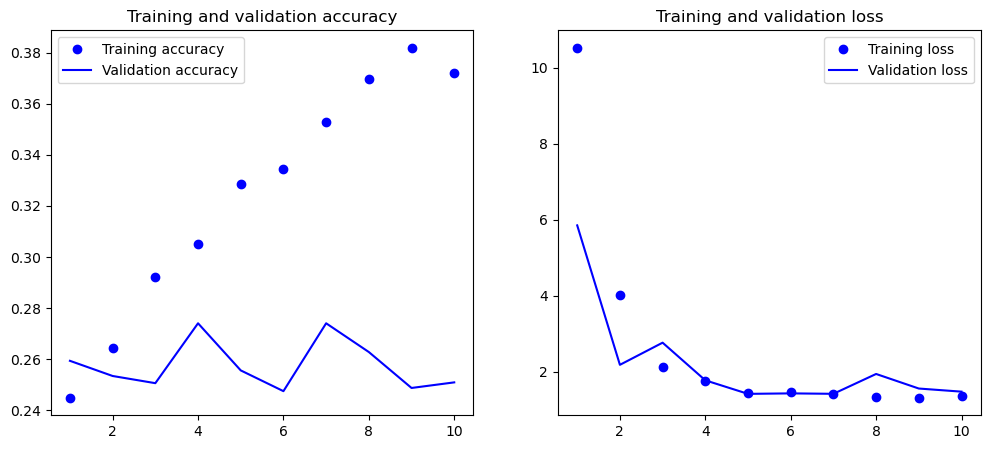

In [10]:
import matplotlib.pyplot as plt

accuracy = history_simple_sar.history['accuracy']
val_accuracy = history_simple_sar.history['val_accuracy']
loss = history_simple_sar.history['loss']
val_loss = history_simple_sar.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Nowy model docelowy SAR

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_simple = Sequential([
    Input(shape=(256, 256, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_simple.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_simple = model_simple.fit(train_generator_sar, validation_data=validation_generator_sar, epochs=10, callbacks=[early_stopping])


c:\Users\piotr\anaconda_inz\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 98s 277ms/step - accuracy: 0.3422 - loss: 1.4041 - val_accuracy: 0.5494 - val_loss: 0.9846
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 240ms/step - accuracy: 0.6162 - loss: 0.9141 - val_accuracy: 0.7528 - val_loss: 0.5805
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.8415 - loss: 0.4151 - val_accuracy: 0.7381 - val_loss: 0.7362
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.9208 - loss: 0.2353 - val_accuracy: 0.8228 - val_loss: 0.4595
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.9526 - loss: 0.1370 - val_accuracy: 0.8666 - val_loss: 0.3580
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.9748 - loss: 0.0662 - val_accuracy: 0.8888 - val_loss: 0.3327
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.9829 - loss: 0.0551 - val_accuracy: 0.8884 - val_loss: 0.3410
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.9863 - loss: 0

In [4]:
test_loss, test_accuracy = model_simple.evaluate(test_generator_sar)

print(f"Wynik na danych testowych:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

c:\Users\piotr\anaconda_inz\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8903 - loss: 0.3237
Wynik na danych testowych:
Test Loss: 0.3089047372341156
Test Accuracy: 0.8931249976158142


# Model z zastosowaniem Dropout 15 epoch

In [5]:
from tensorflow.keras.layers import Dropout

model_simple = Sequential([
    Input(shape=(256, 256, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  
    Dense(4, activation='softmax')
])

model_simple.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_simple = model_simple.fit(train_generator_sar, validation_data=validation_generator_sar, epochs=15, callbacks=[early_stopping])

test_loss, test_accuracy = model_simple.evaluate(test_generator_sar)

print(f"Wynik na danych testowych:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - accuracy: 0.2729 - loss: 1.4981 - val_accuracy: 0.4541 - val_loss: 1.2112
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.4447 - loss: 1.1907 - val_accuracy: 0.5962 - val_loss: 0.9956
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.5675 - loss: 1.0060 - val_accuracy: 0.7025 - val_loss: 0.7831
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.6693 - loss: 0.7755 - val_accuracy: 0.7794 - val_loss: 0.5151
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.7541 - loss: 0.5812 - val_accuracy: 0.8103 - val_loss: 0.4794
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.7697 - loss: 0.5264 - val_accuracy: 0.8000 - val_loss: 0.5133
Epoch 7/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.7961 - loss: 0.4668 - val_accuracy: 0.7728 - val_loss: 0.5149
Epoch 8/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.8076 - loss: 0

# Wykorzystanie Grid Search 

In [7]:
!pip install keras-tuner


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential([
        Input(shape=(256, 256, 1)),
        Conv2D(hp.Choice('filters_1', [16, 32, 64]), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(hp.Choice('filters_2', [32, 64, 128]), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(hp.Choice('filters_3', [64, 128, 256]), (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=10,  
    directory='my_tuning_results',  
    project_name='sar_model_tuning'  
)

tuner.search(
    train_generator_sar,
    validation_data=validation_generator_sar,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry: "
      f"filters_1: {best_hps.get('filters_1')}, "
      f"filters_2: {best_hps.get('filters_2')}, "
      f"filters_3: {best_hps.get('filters_3')}, "
      f"dense_units: {best_hps.get('dense_units')}, "
      f"learning_rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 10m 07s]
val_accuracy: 0.25

Best val_accuracy So Far: 0.9362499713897705
Total elapsed time: 02h 02m 35s
Najlepsze hiperparametry: filters_1: 16, filters_2: 32, filters_3: 64, dense_units: 128, learning_rate: 0.001


# Model z hiperparametrami z grid search

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_simple = Sequential([
    Input(shape=(256, 256, 1)),  
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  
])

model_simple.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_simple = model_simple.fit(
    train_generator_sar,  
    validation_data=validation_generator_sar, 
    epochs=20,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model_simple.evaluate(test_generator_sar)

print(f"Wynik na danych testowych:")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 106s 300ms/step - accuracy: 0.3796 - loss: 1.3517 - val_accuracy: 0.7244 - val_loss: 0.6843
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.7291 - loss: 0.6526 - val_accuracy: 0.8238 - val_loss: 0.4053
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 92s 264ms/step - accuracy: 0.8944 - loss: 0.3018 - val_accuracy: 0.8784 - val_loss: 0.3053
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 257ms/step - accuracy: 0.9537 - loss: 0.1435 - val_accuracy: 0.8291 - val_loss: 0.4538
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 91s 259ms/step - accuracy: 0.9728 - loss: 0.0861 - val_accuracy: 0.9247 - val_loss: 0.2145
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.9759 - loss: 0.0660 - val_accuracy: 0.9069 - val_loss: 0.2729
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 257ms/step - accuracy: 0.9885 - loss: 0.0391 - val_accuracy: 0.9141 - val_loss: 0.2625
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 258ms/step - accuracy: 0.9996 - loss: 